# EDA for loan prediction
The following is my exploration of the data set.  My main goals were:
1. Early detection of which variables would likely be predictive and confirmation of expected relationships (if applicable)
2. Determine which variables needed to be cleaned/imputed
3. Create new variables and check their predictability, if possible

In [2]:
import os
import pandas as pd
import numpy as np
import requests
from sklearn.metrics import r2_score

In [3]:
url = "https://raw.githubusercontent.com/joepollastrini/Loan-Prediction/master"
train_name = 'train_loan_data.csv'
test_name = 'test_loan_data.csv'

In [4]:
def data_grab_online(base, name, out='output.csv'):
    #get data from url
    u = base + '/' + name
    r = requests.get(u).content
    df = pd.read_csv(u)
    return df

In [5]:
#gather data
train = data_grab_online(url, train_name)
test = data_grab_online(url, test_name)

***
***
# Benchmark
How many loans are approved?

In [8]:
train['Loan_Status'].value_counts(normalize=True)

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

Model accuracy needs to be greater than 70%

***
# EDA

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.cbook import boxplot_stats 
from scipy import stats

What are the data types as well as any missing values?

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 12 columns):
Loan_ID              367 non-null object
Gender               356 non-null object
Married              367 non-null object
Dependents           357 non-null object
Education            367 non-null object
Self_Employed        344 non-null object
ApplicantIncome      367 non-null int64
CoapplicantIncome    367 non-null int64
LoanAmount           362 non-null float64
Loan_Amount_Term     361 non-null float64
Credit_History       338 non-null float64
Property_Area        367 non-null object
dtypes: float64(3), int64(2), object(7)
memory usage: 34.5+ KB


****Train missing values:**** 
* Gender (13 / 2.1%)
* Married (3 / 0.5%)
* Dependents (15 / 2.4%)
* Self_Employed (32 / 5.2%)
* LoanAmount (22 / 3.6%)
* Loan_Amount_Term (14 / 2.3%)
* Credit_History (50 / 8.1%)

****Test missing values:**** 
* Gender (11 / 3.0%)
* Dependents (10 / 2.7%)
* Self_Employed (23 / 6.3%)
* LoanAmount (5 / 1.4%)
* Loan_Amount_Term (6 / 1.6%)
* Credit_History (29 / 7.9%)

****Self Employed & Gender have significantly more missing values in test set than train set****

In [8]:
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


* Outliers in income and loan variables
* Most loan terms 30 yr
* 84% of applicants have a credit history

Below is a function to use on every categorical variable.  Will output total count breakdown for the independent variable as well as its normalized counts.  Will also display a graph of the dependent variable breakdown among each category of the independent variable.

In [7]:
def classif_eda(df, ind, dep, other='Property_Area', size=(5,1)):
    #get number of categories for the independent and dependent variables
    num_cats = len(df[ind].dropna().unique())
    num_hue = len(df[dep].unique())
    
    #print total count breakdown and normalize it
    print(df[ind].value_counts())
    print('\n')
    print(df[ind].value_counts(normalize=True))

    #normalized counts per category
    df1 = train.groupby(ind)[dep].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('percent').reset_index()
    
    #plot breakdown
    g = sns.catplot(x=ind, y='percent', hue=dep, kind='bar', data=df1, height=size[0], aspect=size[1])
    g.ax.set_ylim(0,100)

    #label percentages on top of bar
    for p in g.ax.patches:
        txt = str(p.get_height().round(2)) + '%'
        txt_x = p.get_x() 
        txt_y = p.get_height()
        g.ax.text(txt_x,txt_y,txt)
    plt.show()

***
## Gender

Male      489
Female    112
Name: Gender, dtype: int64


Male      0.813644
Female    0.186356
Name: Gender, dtype: float64


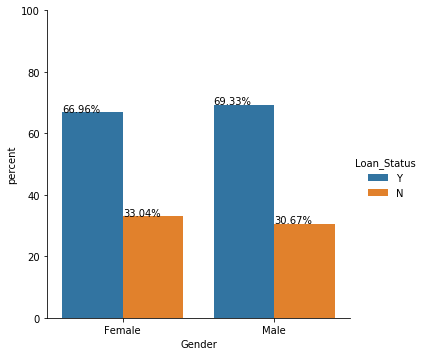

In [10]:
classif_eda(train, 'Gender', 'Loan_Status')

****Takeaways:****
* Loan is more likely to be in males name (81%)
* Gender doesn't seem to have a relationship with loan approval

***
## Married

Yes    398
No     213
Name: Married, dtype: int64


Yes    0.651391
No     0.348609
Name: Married, dtype: float64


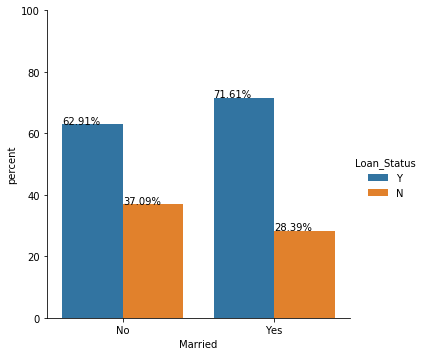

In [11]:
classif_eda(train, 'Married', 'Loan_Status')

****Takeaways:****
* Loan is more likely to be for a married couple (65%)
* Married couple has a higher probability of having loan approved
* This may be due to dual incomes, higher total income?

***
## Married and Gender

### New Variables

In [12]:
train['Gender_Married'] = train['Gender'] + '_' + train['Married']

Male_Yes      357
Male_No       130
Female_No      80
Female_Yes     31
Name: Gender_Married, dtype: int64


Male_Yes      0.596990
Male_No       0.217391
Female_No     0.133779
Female_Yes    0.051839
Name: Gender_Married, dtype: float64


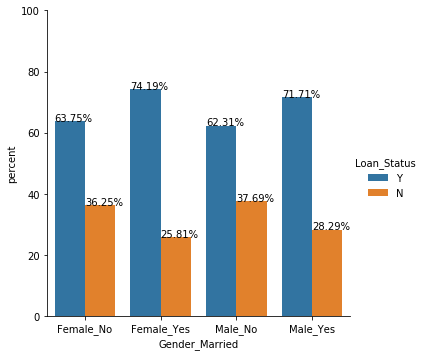

In [13]:
classif_eda(train, 'Gender_Married', 'Loan_Status')

****Takeaways:****
* Despite males having a slightly better chance of a loan approval on their own, when broken down with marriage, females have a higher chance
* Marriage still means a better chance of approval

***
## Dependents

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64


0     0.575960
1     0.170284
2     0.168614
3+    0.085142
Name: Dependents, dtype: float64


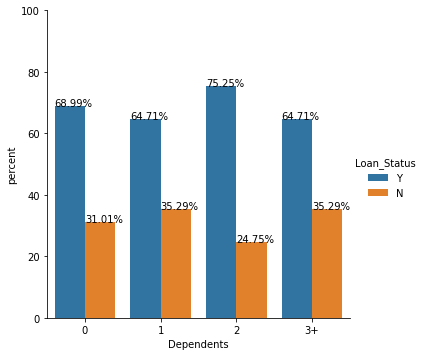

In [14]:
classif_eda(train, 'Dependents', 'Loan_Status')

****Key Takeaways:****
* No discernible relationship here
* Might be better to use variable as ordinal not categorical

***
## Dependents and Married

### New Variables

In [15]:
train['Dependent_Married'] = train['Dependents'] + '_' + train['Married']

0_Yes     174
0_No      171
2_Yes      93
1_Yes      79
3+_Yes     44
1_No       23
2_No        8
3+_No       7
Name: Dependent_Married, dtype: int64


0_Yes     0.290484
0_No      0.285476
2_Yes     0.155259
1_Yes     0.131886
3+_Yes    0.073456
1_No      0.038397
2_No      0.013356
3+_No     0.011686
Name: Dependent_Married, dtype: float64


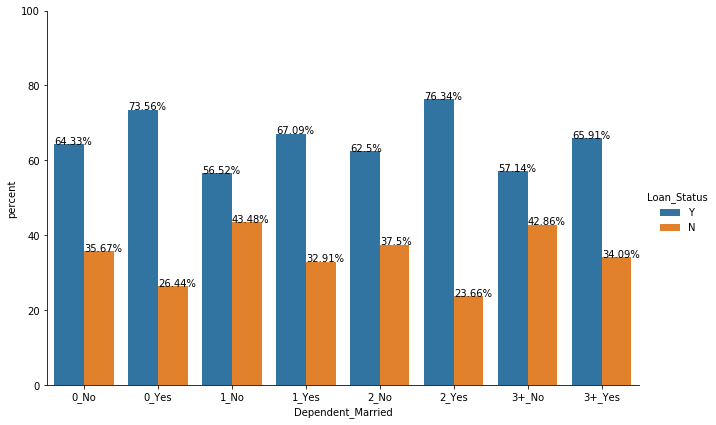

In [16]:
classif_eda(train, 'Dependent_Married', 'Loan_Status', size=(6, 1.5))

****Key Takeaways:****
* As independents increase, probablity of loan approval is increasingly worse if not married

***
## Education

Graduate        480
Not Graduate    134
Name: Education, dtype: int64


Graduate        0.781759
Not Graduate    0.218241
Name: Education, dtype: float64


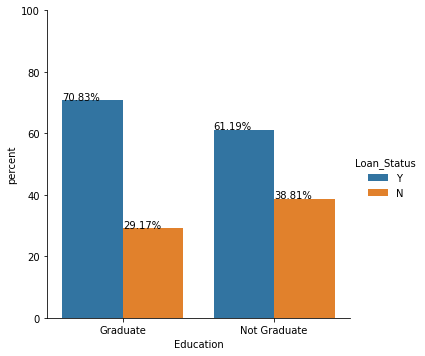

In [17]:
classif_eda(train, 'Education', 'Loan_Status')

****Key Takeaways:****
* Most have higher education (78%)
* Graduated implies better chance of loan approval

***
## Education and Dependents

### New Variables

In [18]:
train['Dependent_Education'] = train['Dependents'] + '_' + train['Education']

0_Graduate         275
1_Graduate          81
2_Graduate          77
0_Not Graduate      70
3+_Graduate         36
2_Not Graduate      24
1_Not Graduate      21
3+_Not Graduate     15
Name: Dependent_Education, dtype: int64


0_Graduate         0.459098
1_Graduate         0.135225
2_Graduate         0.128548
0_Not Graduate     0.116861
3+_Graduate        0.060100
2_Not Graduate     0.040067
1_Not Graduate     0.035058
3+_Not Graduate    0.025042
Name: Dependent_Education, dtype: float64


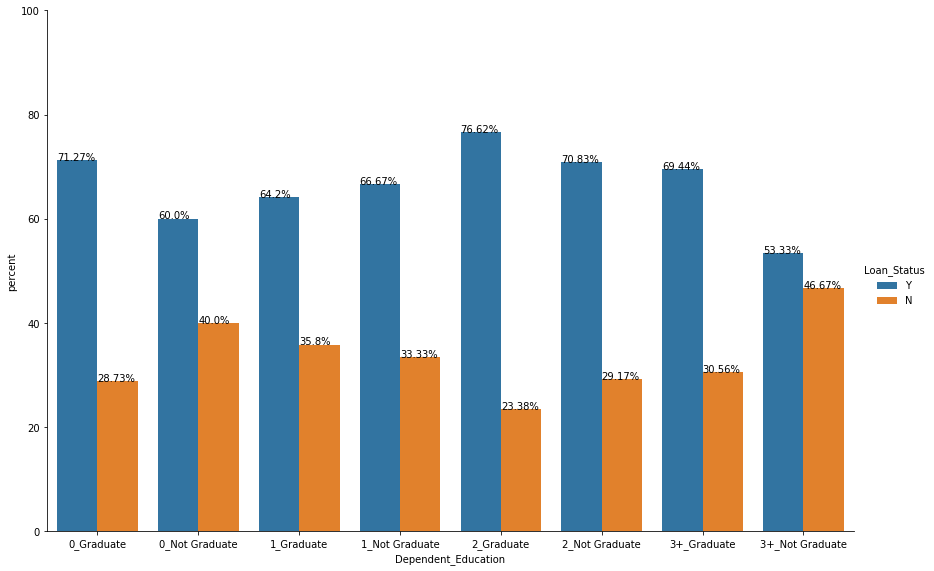

In [19]:
classif_eda(train, 'Dependent_Education', 'Loan_Status', size=(8, 1.5))

***
## Self Employed

No     500
Yes     82
Name: Self_Employed, dtype: int64


No     0.859107
Yes    0.140893
Name: Self_Employed, dtype: float64


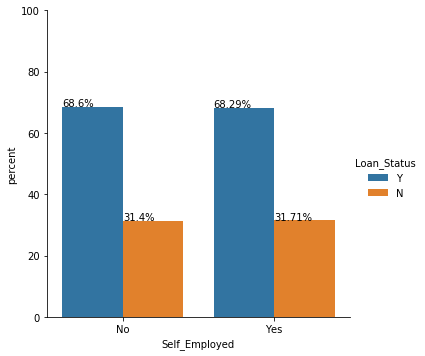

In [20]:
classif_eda(train, 'Self_Employed', 'Loan_Status')

****Key Takeaways:****
* Most are not self employed (86%)
* Very little difference between employment avenue

***
## Loan Amount Term

### New Variables

In [21]:
def loanClass(x):
    if np.isnan(x):
        return np.nan
    else:
        x = int(x)
        if x == 360:
            return '30'
        elif x == 180:
            return '15'
        elif x < 180:
            return '<15'
        elif x > 180 and x < 360:
            return '(15, 30)'
        elif x > 360:
            return '>30'
        else:
            return '??'

In [22]:
train['LoanTermGroups'] = train['Loan_Amount_Term'].apply(lambda x: loanClass(x))

In [23]:
train['Loan_Amount_Term'].value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

Most loan terms are 30 year, and next closest is a 15 year term.  Too small of numbers to do much with for other loan terms, 
group together.

30          512
15           44
(15, 30)     17
>30          15
<15          12
Name: LoanTermGroups, dtype: int64


30          0.853333
15          0.073333
(15, 30)    0.028333
>30         0.025000
<15         0.020000
Name: LoanTermGroups, dtype: float64


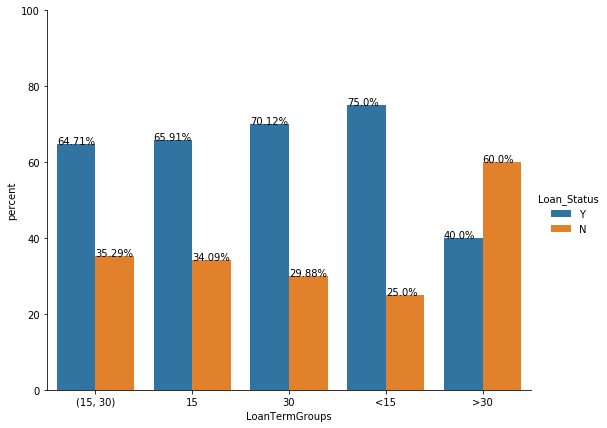

In [24]:
classif_eda(train, 'LoanTermGroups', 'Loan_Status', size=(6,1.25))

****Key Takeaways:****
* Most are 30 year terms (85%)
* Very likely to be approved if less than 15 year loan.  Not a standard home loan?
* Very unlikely to be approved if greater than 30 year loan.  Indicates poor financial situation?

***
## Credit History

1.0    475
0.0     89
Name: Credit_History, dtype: int64


1.0    0.842199
0.0    0.157801
Name: Credit_History, dtype: float64


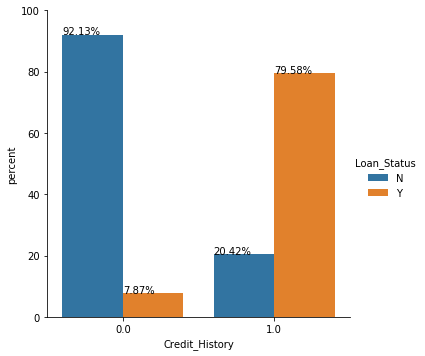

In [25]:
classif_eda(train, 'Credit_History', 'Loan_Status')

****Key Takeaways:****
* Most likely have a history (84%)
* No history means you likely were not approved
* Likely most important variable?
* Careful with imputing missing values here

***
## Property Area

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64


Semiurban    0.379479
Urban        0.328990
Rural        0.291531
Name: Property_Area, dtype: float64


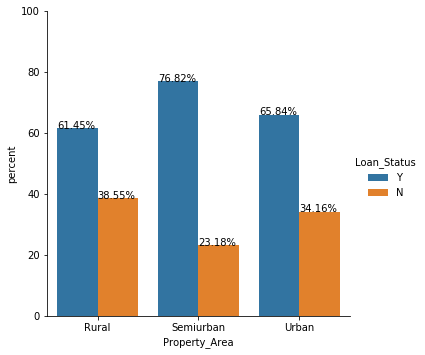

In [26]:
classif_eda(train, 'Property_Area', 'Loan_Status', 'Gender')

****Key Takeaways:****
Small discrpencies between area could be useful

Below is a function to explore continuous variables.  This is mostly used to show outliers and its overall distribution with a normal curve drawn over.

In [27]:
def contin_outliers(df, ind):
    #remove missing values
    df.dropna(subset = [ind], inplace=True)
    
    #plot figures
    fig = plt.figure(figsize=(15, 12), dpi= 80, facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace=0.35, wspace=0.1)
    
    #print box and whiskers
    ax1 = fig.add_subplot(3, 2, 1)
    ax1.set_title('Box and Whiskers Normal')
    sns.boxplot(df[ind])
    
    #distribution plot
    ax2 = fig.add_subplot(3, 2, 3)
    ax2.set_title('Distribution Normal with Outliers')
    sns.distplot(df[ind], kde=False, fit=stats.norm)
    
    #outliers
    box = boxplot_stats(df[ind])[0]
    outliers = box['fliers']
    print('Num Outliers:  {}'.format(len(outliers)))
    lowCut = box['whislo']
    highCut = box['whishi']
    df1 = df.copy()
    df1['Inlier'] = df1[ind].apply(lambda x: 1 if (x > lowCut and x < highCut) else 0)
    inliers = df1[df1['Inlier'] == 1]
    
    #distribution of inliers
    ax3 = fig.add_subplot(3, 2, 5)
    ax3.set_title('Distribution Normal without Outliers')
    sns.distplot(inliers[ind], kde=False, fit=stats.norm)
    
    
    ## Log transform ##
    df['Log'] = np.log(df[ind])
    
    #box and whiskers of log transformed
    ax4 = fig.add_subplot(3, 2, 2)
    ax4.set_title('Box and Whiskers Logged')
    sns.boxplot(df['Log'])
    
    #distribution plot of log transformed
    ax5 = fig.add_subplot(3, 2, 4)
    ax5.set_title('Distribution Logged with Outliers')
    sns.distplot(df['Log'], kde=False, fit=stats.norm)
    
    #outliers of log transformed
    box = boxplot_stats(df['Log'])[0]
    outliers = box['fliers']
    print('Num Outliers (Log):  {}'.format(len(outliers)))
    lowCut = box['whislo']
    highCut = box['whishi']
    df['Inlier'] = df['Log'].apply(lambda x: 1 if (x > lowCut and x < highCut) else 0)
    inliers = df.loc[df['Inlier'] == 1]
    
    #distribution of outliers of log transformed
    ax6 = fig.add_subplot(3, 2, 6)
    ax6.set_title('Distribution Logged without Outliers')
    sns.distplot(inliers['Log'], kde = False, fit = stats.norm)

***
## Income

### New Variables

In [28]:
train['TotalIncome'] = train['ApplicantIncome'] + train['CoapplicantIncome']
train['IncomeQuart'] = pd.qcut(train['TotalIncome'], 4, labels = ['IncomeQ1', 'IncomeQ2', 'IncomeQ3', 'IncomeQ4'])
train['IncomeDec'] = pd.qcut(train['TotalIncome'], 10)

IncomeQ1    155
IncomeQ4    154
IncomeQ3    153
IncomeQ2    152
Name: IncomeQuart, dtype: int64


IncomeQ1    0.252443
IncomeQ4    0.250814
IncomeQ3    0.249186
IncomeQ2    0.247557
Name: IncomeQuart, dtype: float64


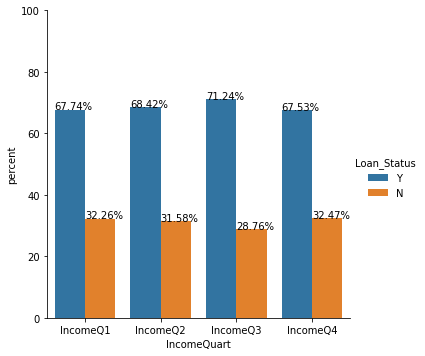

In [29]:
classif_eda(train, 'IncomeQuart', 'Loan_Status')

Pretty similar for each quartile

(11462.8, 81000.0]    62
(6787.2, 8334.0]      62
(6042.6, 6787.2]      62
(4402.7, 4807.4]      62
(1441.999, 3245.8]    62
(5416.5, 6042.6]      61
(4807.4, 5416.5]      61
(3812.6, 4402.7]      61
(3245.8, 3812.6]      61
(8334.0, 11462.8]     60
Name: IncomeDec, dtype: int64


(11462.8, 81000.0]    0.100977
(6787.2, 8334.0]      0.100977
(6042.6, 6787.2]      0.100977
(4402.7, 4807.4]      0.100977
(1441.999, 3245.8]    0.100977
(5416.5, 6042.6]      0.099349
(4807.4, 5416.5]      0.099349
(3812.6, 4402.7]      0.099349
(3245.8, 3812.6]      0.099349
(8334.0, 11462.8]     0.097720
Name: IncomeDec, dtype: float64


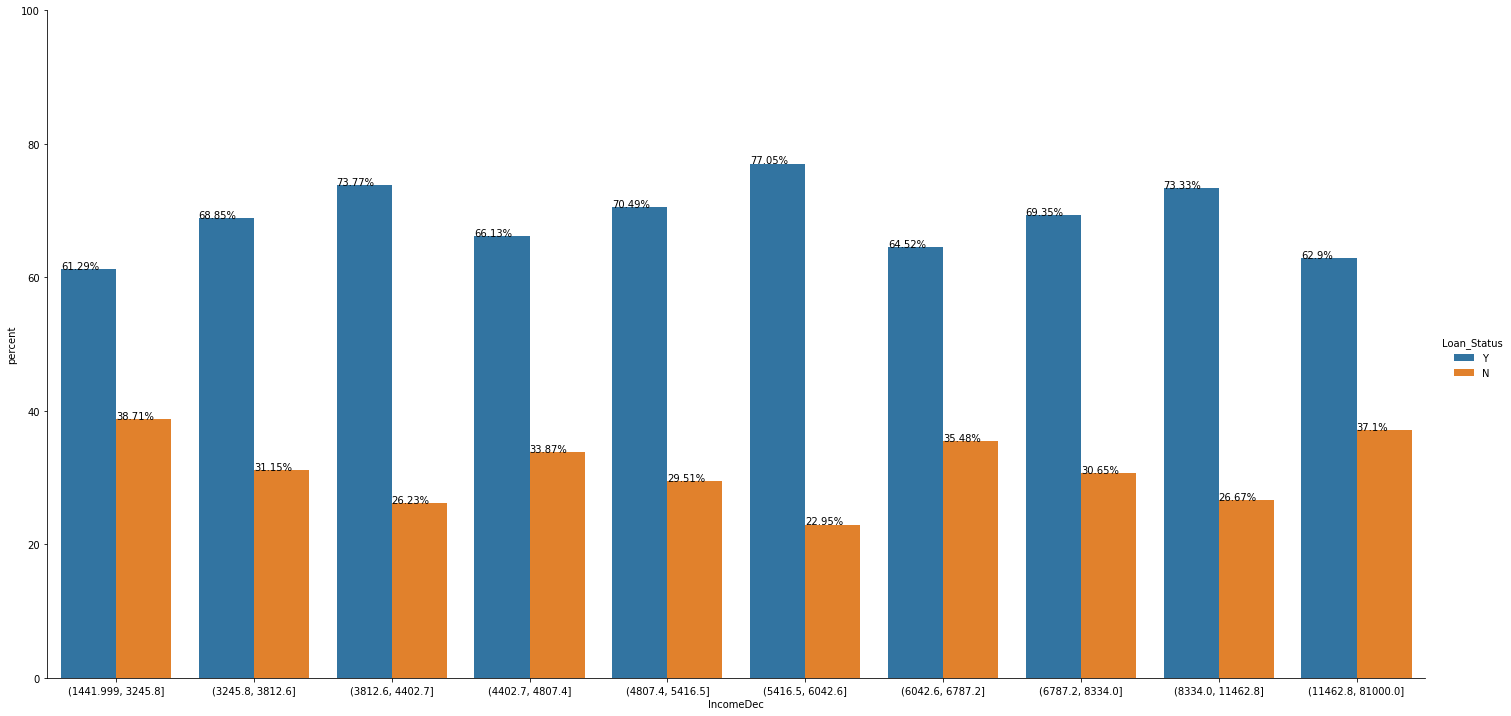

In [30]:
classif_eda(train, 'IncomeDec', 'Loan_Status', size=(10, 2))

Interesting pattern but likely not anything explanatory

****Key Takeaways:****
* Not much difference per quartile
* Not an explanatory variable? surprising

##### Look at outliers

Num Outliers:  50
Num Outliers (Log):  22


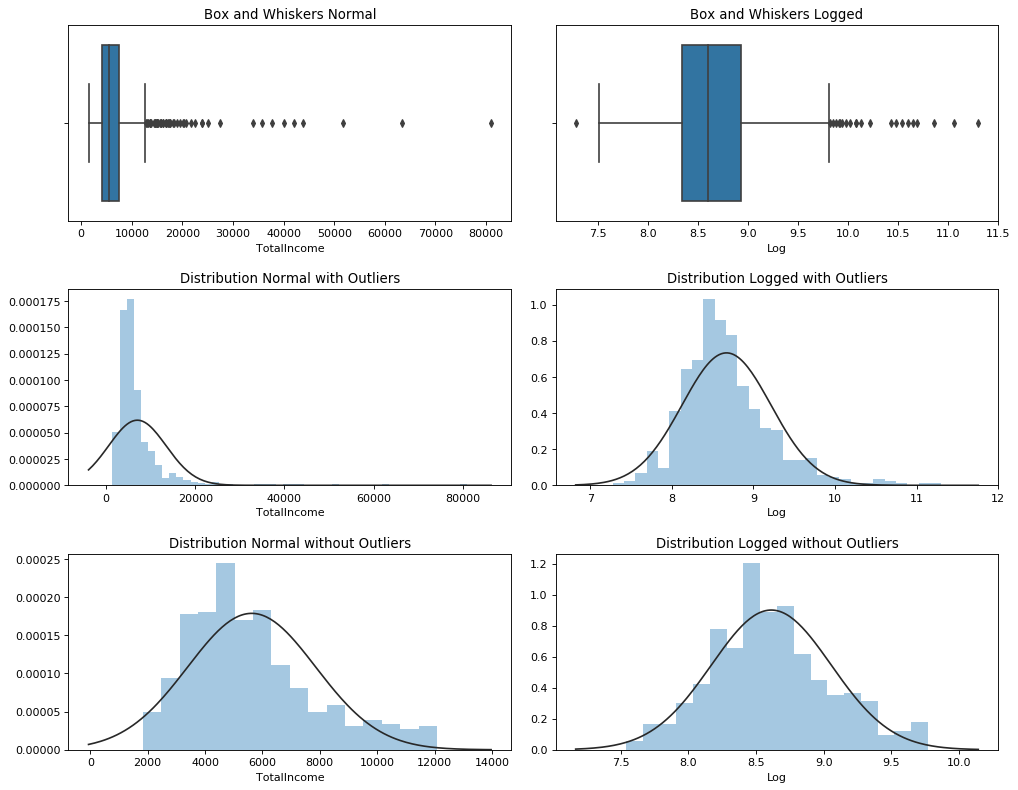

In [31]:
inliers = contin_outliers(train, 'TotalIncome')

***
## Loan Amount

### New Variables

In [32]:
train['LAQuart'] = pd.qcut(train['LoanAmount'], 4, labels = ['LAQ1', 'LAQ2', 'LAQ3', 'LAQ4'])
train['LADec'] = pd.qcut(train['LoanAmount'], 10)

LAQ1    154
LAQ2    152
LAQ4    146
LAQ3    140
Name: LAQuart, dtype: int64


LAQ1    0.260135
LAQ2    0.256757
LAQ4    0.246622
LAQ3    0.236486
Name: LAQuart, dtype: float64


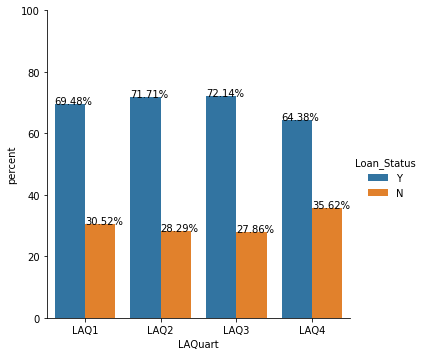

In [33]:
classif_eda(train, 'LAQuart', 'Loan_Status')

(116.0, 128.0]    65
(137.0, 158.0]    63
(95.0, 108.0]     62
(8.999, 71.0]     61
(235.8, 700.0]    60
(108.0, 116.0]    59
(71.0, 95.0]      59
(158.0, 182.0]    57
(182.0, 235.8]    56
(128.0, 137.0]    50
Name: LADec, dtype: int64


(116.0, 128.0]    0.109797
(137.0, 158.0]    0.106419
(95.0, 108.0]     0.104730
(8.999, 71.0]     0.103041
(235.8, 700.0]    0.101351
(108.0, 116.0]    0.099662
(71.0, 95.0]      0.099662
(158.0, 182.0]    0.096284
(182.0, 235.8]    0.094595
(128.0, 137.0]    0.084459
Name: LADec, dtype: float64


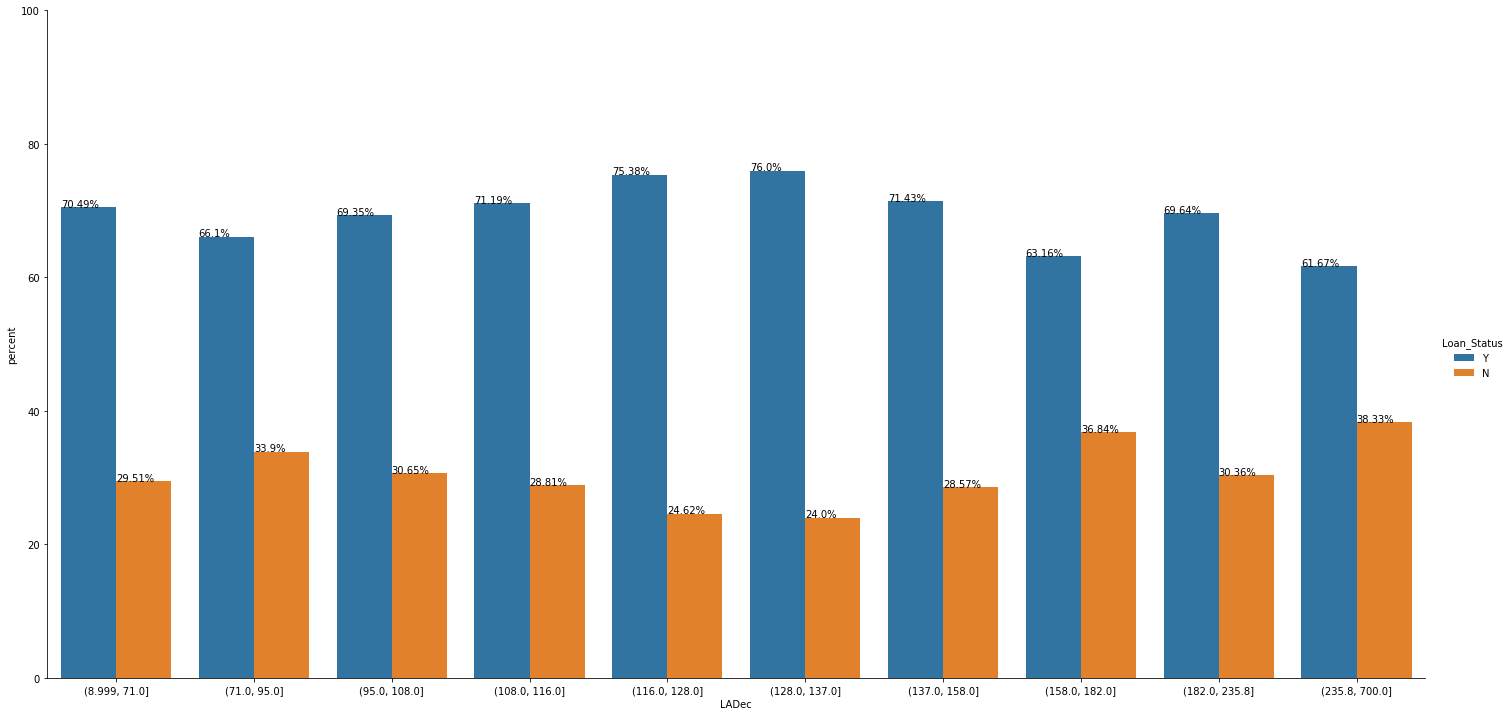

In [34]:
classif_eda(train, 'LADec', 'Loan_Status', size=(10,2))

Num Outliers:  39
Num Outliers (Log):  34


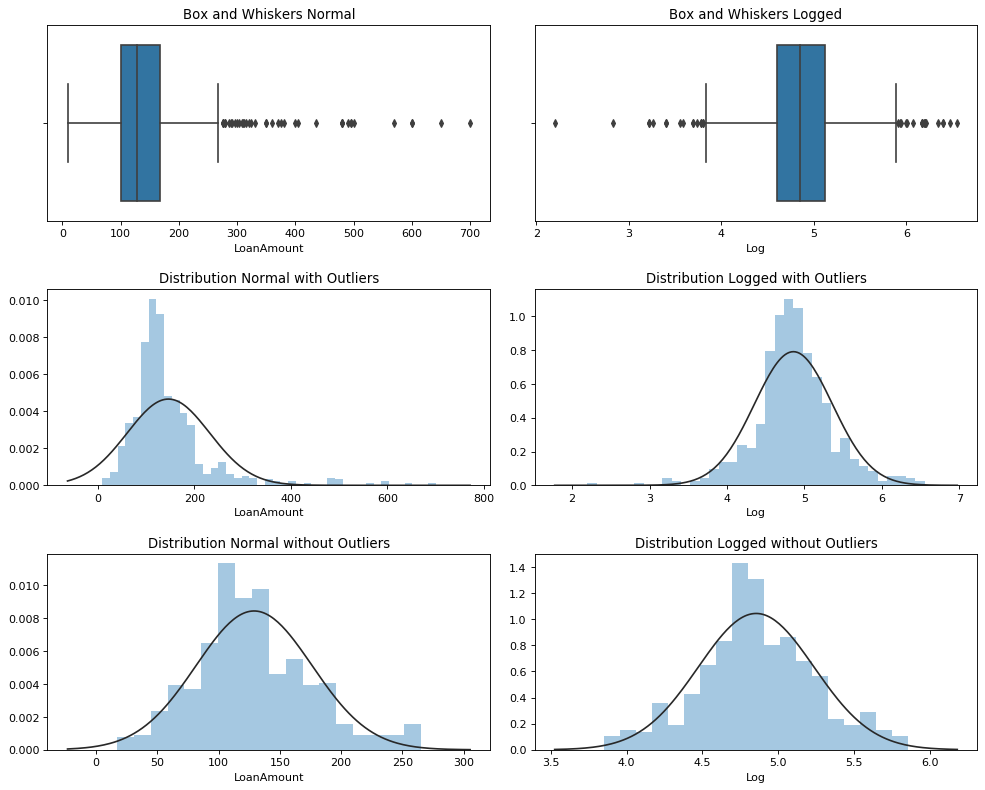

In [35]:
contin_outliers(train, 'LoanAmount')

***
## Feature Engineering EDA

***
## Dual Income Indicator

In [36]:
def dual_ind(x):
    if x['Married'] == 'Yes':
        if x['CoapplicantIncome'] > 0:
            return 1
        else:
            return 0
    else:
        return 0

In [37]:
train['DualIncome_IO'] = train.apply(lambda x: dual_ind(x), axis=1)

0    330
1    262
Name: DualIncome_IO, dtype: int64


0    0.557432
1    0.442568
Name: DualIncome_IO, dtype: float64


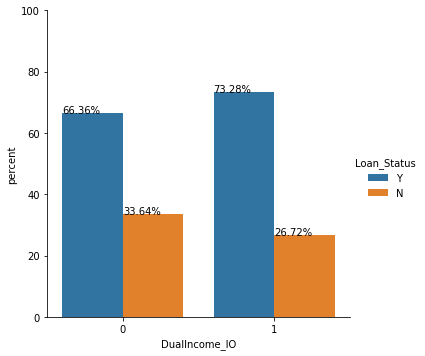

In [38]:
classif_eda(train, 'DualIncome_IO', 'Loan_Status')

****Key Takeaways:****
1. A little better chance of loan approval if dual income

***
## Family Size

In [39]:
train.dropna(subset=['Dependents'], inplace=True)
train['DependentsOrd'] = train['Dependents'].apply(lambda x: 3 if x == '3+' else int(x))
train['Married_IO'] = train['Married'].apply(lambda x: 1 if x=='Yes' else 0)
train['FamilySize'] = train['DependentsOrd'] + train['Married_IO'] + 1

2    190
1    166
4     96
3     84
5     43
Name: FamilySize, dtype: int64


2    0.328152
1    0.286701
4    0.165803
3    0.145078
5    0.074266
Name: FamilySize, dtype: float64


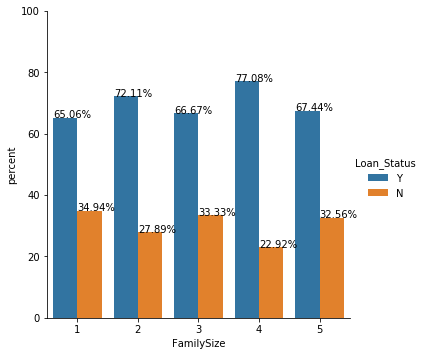

In [40]:
classif_eda(train, 'FamilySize', 'Loan_Status')

***
## Loan Amount per Income
Loan amount divided by income

Designed to express how much an applicant is extending themself.  Higher implies more extended.

In [41]:
train['LoanPerIncome'] = train['LoanAmount'] * 1000 / train['TotalIncome']
train['LoanPerIncome'].describe()

count    579.000000
mean      23.714134
std        8.323388
min        2.522916
25%       19.182013
50%       24.114265
75%       28.116392
max       82.711645
Name: LoanPerIncome, dtype: float64

In [42]:
train['LoanIncomeQuart'] = pd.qcut(train['LoanPerIncome'], 4, labels = ['LIQ1', 'LIQ2', 'LIQ3', 'LIQ4'])

LIQ4    145
LIQ2    145
LIQ1    145
LIQ3    144
Name: LoanIncomeQuart, dtype: int64


LIQ4    0.250432
LIQ2    0.250432
LIQ1    0.250432
LIQ3    0.248705
Name: LoanIncomeQuart, dtype: float64


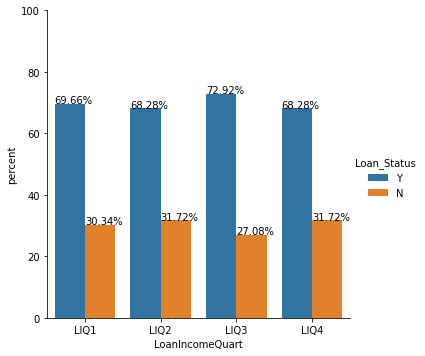

In [43]:
classif_eda(train, 'LoanIncomeQuart', 'Loan_Status')

Num Outliers:  22
Num Outliers (Log):  39


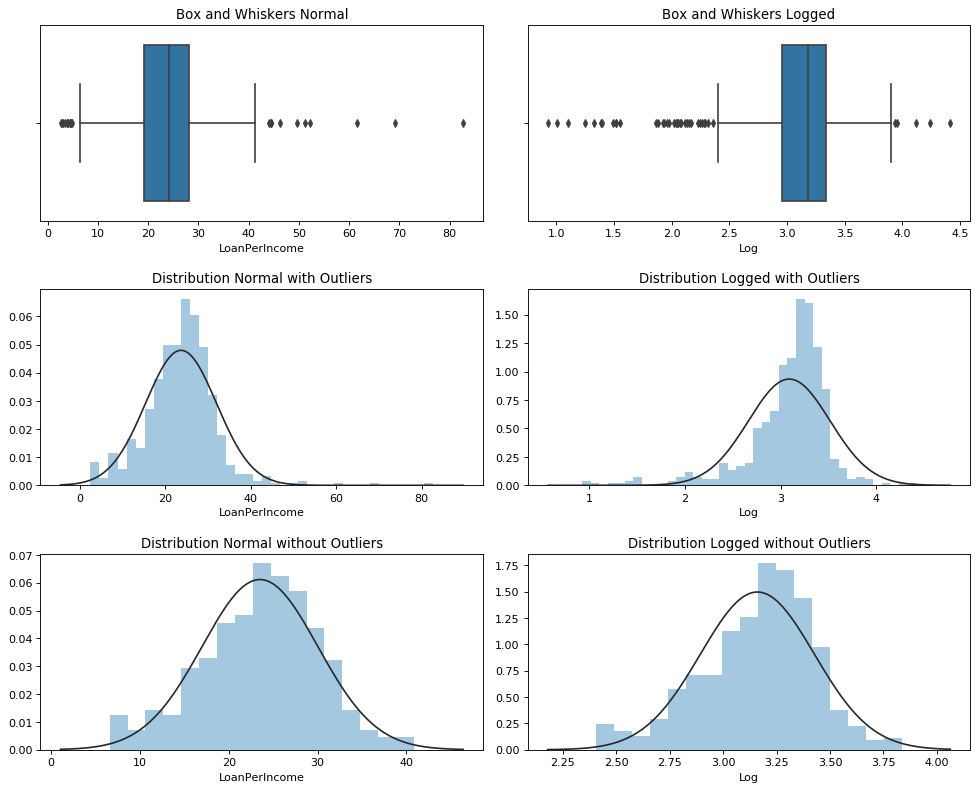

In [44]:
contin_outliers(train, 'LoanPerIncome')

****Key Takeaways:****
* Hard to tell if predictive/a relationship
* Seems better to not log transform

***
## Loan Amount Per Year Per Term
1. Loan Amount / Term == amount per year
2. divide that by income

Designed to show how much of an applicants income is going to the loan per year.  Obviously not exact due to lack of interest rates, but still a decent look.

In [45]:
train['LoanPerYear'] = (train['LoanAmount'] * 1000 / train['Loan_Amount_Term']) * 12
train['LoanEquity/Year'] = train['LoanPerYear'] / train['TotalIncome']
train['LoanEquity/Year'].describe()

count    566.000000
mean       0.930734
std        0.978386
min        0.084097
25%        0.666144
50%        0.829010
75%        0.980957
max       14.842478
Name: LoanEquity/Year, dtype: float64

In [46]:
train['LoanIncomeYearQuart'] = pd.qcut(train['LoanEquity/Year'], 4, labels = ['LIyQ1', 'LIyQ2', 'LIyQ3', 'LIyQ4'])

LIyQ4    142
LIyQ1    142
LIyQ3    141
LIyQ2    141
Name: LoanIncomeYearQuart, dtype: int64


LIyQ4    0.250883
LIyQ1    0.250883
LIyQ3    0.249117
LIyQ2    0.249117
Name: LoanIncomeYearQuart, dtype: float64


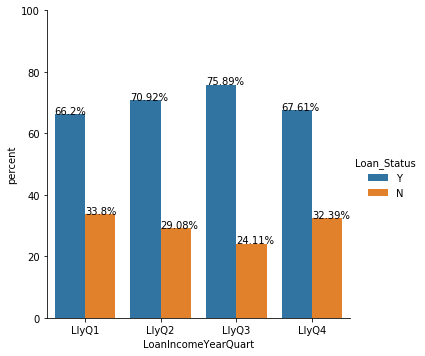

In [47]:
classif_eda(train, 'LoanIncomeYearQuart', 'Loan_Status')

Num Outliers:  46
Num Outliers (Log):  46


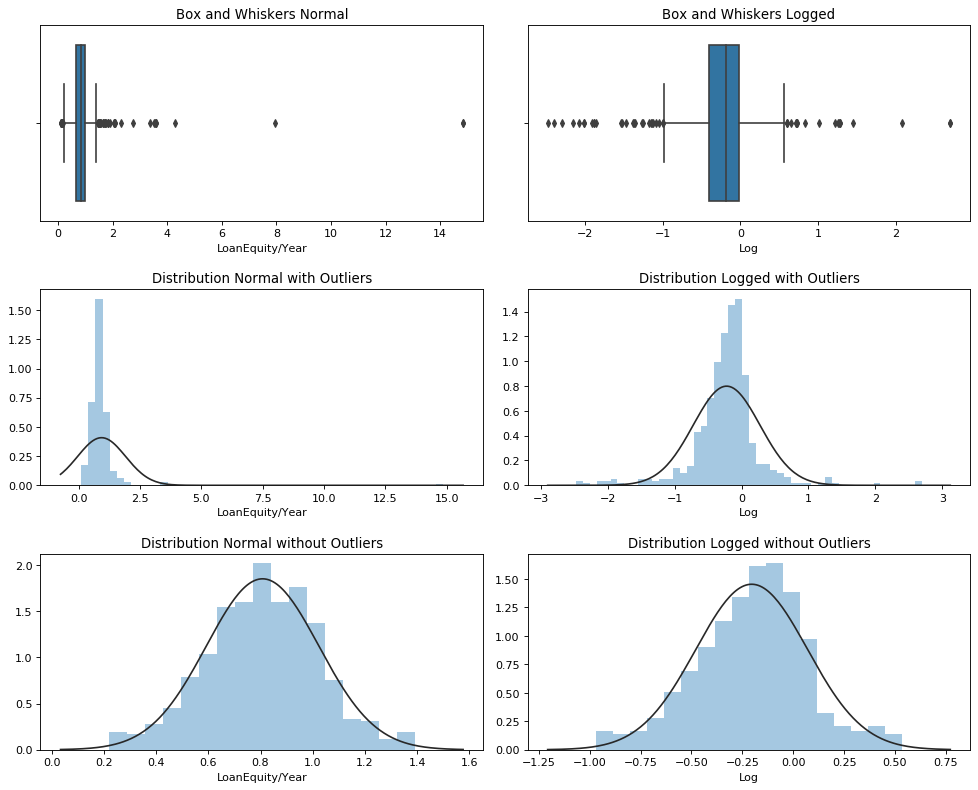

In [48]:
contin_outliers(train, 'LoanEquity/Year')

****Key Takeaway:****
* Unexpected, as total income used for loan per year goes up, so does your probablity of getting approved for loan, until 4th 
quartile?
* Just remove outliers? No log transform?

***
## Income per Family Size
Income / Number of family members

In [49]:
train['IncomePerMember'] = train['TotalIncome'] / train['FamilySize']
train['IncomePerMember'].describe()

count      566.00000
mean      3711.12222
std       3619.42261
min        565.00000
25%       1727.25000
50%       2717.50000
75%       4299.75000
max      35673.00000
Name: IncomePerMember, dtype: float64

In [50]:
train['IncomePerMemberQuart'] = pd.qcut(train['IncomePerMember'], 4, labels = ['IMQ1', 'IMQ2', 'IMQ3', 'IMQ4'])

IMQ4    142
IMQ1    142
IMQ3    141
IMQ2    141
Name: IncomePerMemberQuart, dtype: int64


IMQ4    0.250883
IMQ1    0.250883
IMQ3    0.249117
IMQ2    0.249117
Name: IncomePerMemberQuart, dtype: float64


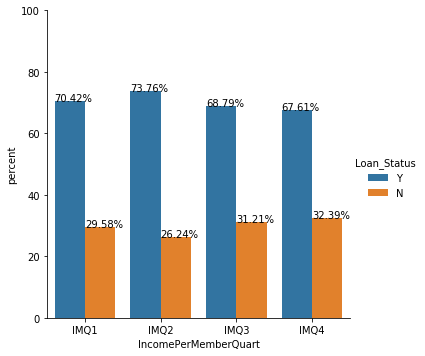

In [51]:
classif_eda(train, 'IncomePerMemberQuart', 'Loan_Status')

Num Outliers:  43
Num Outliers (Log):  9


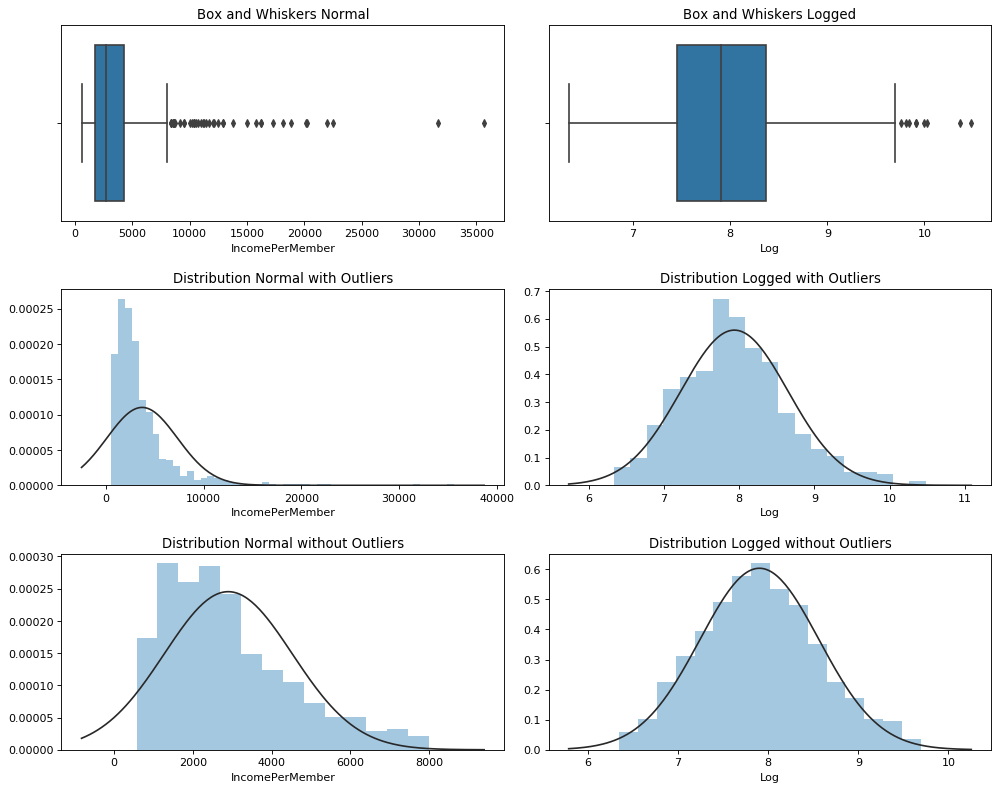

In [52]:
contin_outliers(train, 'IncomePerMember')

****Key Takeaway:****
* Log transform seems best

***
***
## Correlations

In [53]:
forCorr = train[['TotalIncome', 'LoanAmount'
                                 , 'LoanPerIncome', 'LoanPerYear'
                                 , 'LoanEquity/Year', 'IncomePerMember']]

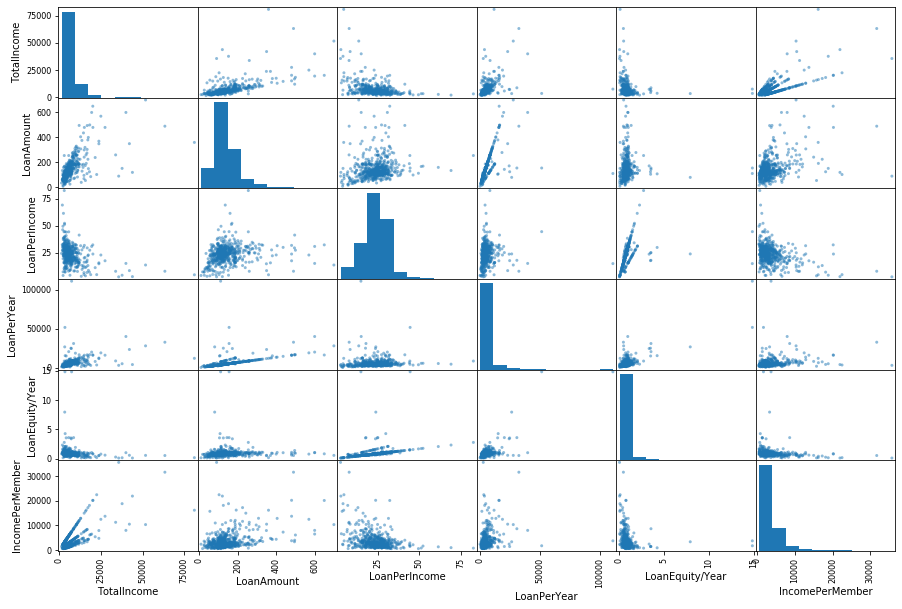

In [54]:
pd.plotting.scatter_matrix(forCorr, figsize=(15,10));

In [55]:
forCorr.corr()

,TotalIncome,LoanAmount,LoanPerIncome,LoanPerYear,LoanEquity/Year,IncomePerMember
TotalIncome,1.000000,0.624610,-0.386227,0.366257,-0.128715,0.696078
LoanAmount,0.624610,1.000000,0.167567,0.489667,0.018336,0.389405
LoanPerIncome,-0.386227,0.167567,1.000000,0.026198,0.294116,-0.370179
LoanPerYear,0.366257,0.489667,0.026198,1.000000,0.759818,0.202757
LoanEquity/Year,-0.128715,0.018336,0.294116,0.759818,1.000000,-0.138918
IncomePerMember,0.696078,0.389405,-0.370179,0.202757,-0.138918,1.000000


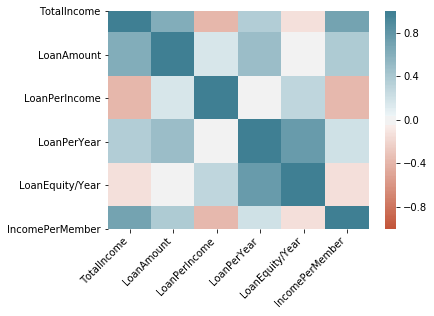

In [56]:
ax = sns.heatmap(
    forCorr.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

****Highly Correlated****
* LoanEquity/Year and LoanPerYear (0.76)
* TotalIncome and LoanAmount (0.62)

****Highly Inversely Correlated****
* LoanPerIncome and TotalIncome (-0.39)
* LoanPerIncome and IncomePerMember (-0.37)